In [15]:

import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
import keras


In [16]:
pixel_size = 150
data_folder = f"A1_data_{pixel_size}"
images_path = os.path.join(data_folder, "images.npy")
images = np.load(images_path)
labels_path = os.path.join(data_folder, "labels.npy")
labels = np.load(labels_path)

Our first experiment is building a classification model
we will start with dividing the feature space into 24,72 & 720 labels

Function that allows us to make N_classes (note: it does not work for less than 12 classes)

In [17]:
dct = {}
def get_cat_labels(labels, N_classes):
    new_labels = []
    for label in labels:
        old = (label[0],label[1])
        label = label[0]* N_classes/12+ int(label[1]* N_classes/(12*60))
        dct[old]=label
        new_labels.append(int(label))
    return np.array(new_labels)


We then split the data into training, validation, and test sets. The sklearn train_test_split method shuffles the data by default

In [18]:

X_train_full, X_test,y_train_full, y_test = train_test_split(
    images, labels, test_size=0.1, random_state=35
)
X_train, X_valid,y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=1/9, random_state=35
) # 1/9 x 0.9 = 0.1.


we define a common sense loss. This will calculate how far of the prediction was

In [19]:
def make_common_sense_loss(num_classes=24.0):
    def common_sense_loss(y_true, y_pred):
        y_pred_class = tf.argmax(y_pred, axis=1)
        y_true_float = tf.cast(tf.squeeze(y_true), dtype=tf.float32)
        y_pred_float = tf.cast(y_pred_class, dtype=tf.float32)
        diff = tf.abs(y_true_float - y_pred_float)
        cyclical_diff = tf.minimum(diff, num_classes- diff)
        return tf.reduce_mean(cyclical_diff * 720 /num_classes)
    return common_sense_loss

In [20]:
def create_model(num_classes=24):
    lr_scheduler = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,          # halve the learning rate if there is no improvement
        patience=5,          # Wait 3 epochs with no improvement before reducing
        min_lr=1e-6          # Set a minimum learning rate at 1e-6
    )
    early_stopper = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=7,          # Wait 5 epochs for improvement before stopping
        restore_best_weights=True  # Automatically restore the weights from the best epoch
    )
    csv_logger = keras.callbacks.CSVLogger(
    filename=f"classification_log{num_classes}_classes.csv",
    separator=",",
    append=True)  #makes sure results are appended to same file if training stops and is resumed
    model= keras.models.Sequential([
        keras.Input(shape=(pixel_size, pixel_size, 1)),
        #feature augmentation
        keras.layers.RandomRotation(factor=(8 / 360)),
        keras.layers.RandomTranslation(height_factor=0.03, width_factor=0.03),
        keras.layers.RandomZoom(height_factor=0.03, width_factor=0.03),
        # Block 1
        keras.layers.Conv2D(32, (3,3), activation="relu", padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(32, (3,3), activation="relu", padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2,2)),
        keras.layers.Dropout(0.1),
        # Block 2
        keras.layers.Conv2D(64, (3,3), activation="relu", padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(64, (3,3), activation="relu", padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(2),
        keras.layers.Dropout(0.1),
        # Block 3
        keras.layers.Conv2D(128, (3,3), activation="relu", padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(128, (3,3), activation="relu", padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(2),
        keras.layers.Dropout(0.1),
        # Block 4
        keras.layers.Conv2D(256, (3,3), activation="relu", padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(256, (3,3), activation="relu", padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(2),
        keras.layers.Dropout(0.1),


        keras.layers.Flatten(),
        keras.layers.Dense(128, activation="leaky_relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation="leaky_relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(int(num_classes), activation="softmax")
    ])
    cse = make_common_sense_loss(num_classes=num_classes)
    model.compile(loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    # optimizer=keras.optimizers.RMSprop(learning_rate=0.0001),
    metrics=[cse,"Accuracy"
            ],
    )
    return model, lr_scheduler, early_stopper, csv_logger


In [21]:

for num_classes in [12,72,720]:
    model, lr_scheduler, early_stopper, csv_logger = create_model(num_classes=num_classes)
    train_labels = get_cat_labels(y_train,num_classes)
    valid_labels = get_cat_labels(y_valid,num_classes)
    test_labels = get_cat_labels(y_test,num_classes)
    history = model.fit(
        X_train, train_labels,
        epochs=50,
        # batch_size=16,
        validation_data=(X_valid, valid_labels),
        callbacks=[lr_scheduler, early_stopper, csv_logger]
    )
    test_loss, test_cse, test_accuracy = model.evaluate(X_test, test_labels)
    model.save(f"classification_model_{num_classes}_classes.keras")
    print(f"{num_classes} Classes: \n Test Loss: {test_loss}, Test Common Sense Error: {test_cse}, Test Accuracy: {test_accuracy}")

Epoch 1/50


E0000 00:00:1762362595.767571   11765 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_2_1/dropout_8_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


450/450 ━━━━━━━━━━━━━━━━━━━━ 46s 98ms/step - Accuracy: 0.0982 - common_sense_loss: 168.8667 - loss: 2.7945 - val_Accuracy: 0.1017 - val_common_sense_loss: 165.9211 - val_loss: 2.6457 - learning_rate: 1.0000e-04
Epoch 2/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 44s 98ms/step - Accuracy: 0.1352 - common_sense_loss: 143.1417 - loss: 2.4792 - val_Accuracy: 0.1167 - val_common_sense_loss: 148.6184 - val_loss: 2.5998 - learning_rate: 1.0000e-04
Epoch 3/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 44s 98ms/step - Accuracy: 0.1855 - common_sense_loss: 116.0750 - loss: 2.2762 - val_Accuracy: 0.1439 - val_common_sense_loss: 130.3947 - val_loss: 2.4650 - learning_rate: 1.0000e-04
Epoch 4/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 44s 98ms/step - Accuracy: 0.2269 - common_sense_loss: 103.3333 - loss: 2.1061 - val_Accuracy: 0.1728 - val_common_sense_loss: 125.8224 - val_loss: 2.4411 - learning_rate: 1.0000e-04
Epoch 5/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 44s 98ms/step - Accuracy: 0.2872 - common_sense_loss: 89.7625 - loss: 1.9093 - val_

E0000 00:00:1762364456.143705   11765 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_3_1/dropout_14_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


450/450 ━━━━━━━━━━━━━━━━━━━━ 47s 99ms/step - Accuracy: 0.0167 - common_sense_loss: 177.2146 - loss: 4.4997 - val_Accuracy: 0.0228 - val_common_sense_loss: 171.2336 - val_loss: 4.6195 - learning_rate: 1.0000e-04
Epoch 2/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 44s 98ms/step - Accuracy: 0.0244 - common_sense_loss: 169.2903 - loss: 4.3231 - val_Accuracy: 0.0306 - val_common_sense_loss: 161.4912 - val_loss: 5.4682 - learning_rate: 1.0000e-04
Epoch 3/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 44s 98ms/step - Accuracy: 0.0477 - common_sense_loss: 149.4236 - loss: 4.0964 - val_Accuracy: 0.0417 - val_common_sense_loss: 159.0789 - val_loss: 5.7068 - learning_rate: 1.0000e-04
Epoch 4/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 44s 98ms/step - Accuracy: 0.0841 - common_sense_loss: 134.4042 - loss: 3.7848 - val_Accuracy: 0.0594 - val_common_sense_loss: 147.2039 - val_loss: 4.6631 - learning_rate: 1.0000e-04
Epoch 5/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 44s 98ms/step - Accuracy: 0.1113 - common_sense_loss: 125.2111 - loss: 3.4475 - val

E0000 00:00:1762366403.836404   11765 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_4_1/dropout_20_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


450/450 ━━━━━━━━━━━━━━━━━━━━ 47s 99ms/step - Accuracy: 0.0014 - common_sense_loss: 181.0708 - loss: 6.6732 - val_Accuracy: 0.0011 - val_common_sense_loss: 179.6672 - val_loss: 6.8979 - learning_rate: 1.0000e-04
Epoch 2/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 44s 98ms/step - Accuracy: 0.0015 - common_sense_loss: 178.9230 - loss: 6.6437 - val_Accuracy: 0.0000e+00 - val_common_sense_loss: 176.8300 - val_loss: 6.9812 - learning_rate: 1.0000e-04
Epoch 3/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 44s 98ms/step - Accuracy: 0.0017 - common_sense_loss: 179.3458 - loss: 6.6248 - val_Accuracy: 5.5556e-04 - val_common_sense_loss: 177.8777 - val_loss: 7.0206 - learning_rate: 1.0000e-04
Epoch 4/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 44s 98ms/step - Accuracy: 0.0019 - common_sense_loss: 177.0465 - loss: 6.6103 - val_Accuracy: 0.0011 - val_common_sense_loss: 182.7818 - val_loss: 7.0434 - learning_rate: 1.0000e-04
Epoch 5/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 44s 98ms/step - Accuracy: 0.0020 - common_sense_loss: 171.3798 - loss: 6.59

Regression model. less dropout as this is less prone to overfitting

feat prep

In [28]:
import sklearn.preprocessing
labels_minutes = labels[:,0]*60 + labels[:,1]
labels_minutes = sklearn.preprocessing.MinMaxScaler(feature_range=(0,1)).fit_transform(labels_minutes.reshape(-1,1)).flatten()
images = images.astype('float32') / 255.0
X_train_full, X_test,y_train_full, y_test = train_test_split(
    images, labels_minutes, test_size=0.1, random_state=35
)
X_train, X_valid,y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=1/9, random_state=35
)

In [29]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,          # halve the learning rate if there is no improvement
    patience=3,          # Wait 3 epochs with no improvement before reducing
    min_lr=1e-6          # Set a minimum learning rate at 1e-6
)
early_stopper = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,          # Wait 5 epochs for improvement before stopping
    restore_best_weights=True  # Automatically restore the weights from the best epoch
)
csv_logger = keras.callbacks.CSVLogger(
filename=f"regression_log.csv",
separator=",",
append=True)
model= keras.models.Sequential([
    keras.Input(shape=(pixel_size, pixel_size, 1)),
    #feature augmentation
    keras.layers.RandomRotation(factor=(12 / 360)),
    keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    keras.layers.RandomZoom(height_factor=0.1, width_factor=0.1),
    # Block 1
    keras.layers.Conv2D(32, (3,3), activation="relu", padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2,2)),
    # keras.layers.Dropout(0.1),
    # Block 2
    keras.layers.Conv2D(64, (3,3), activation="relu", padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3,3), activation="relu", padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2),
    # keras.layers.Dropout(0.1),
    # Block 3
    keras.layers.Conv2D(128, (3,3), activation="relu", padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (3,3), activation="relu", padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2),
    # keras.layers.Dropout(0.1),
    # Block 4
    keras.layers.Conv2D(256, (3,3), activation="relu", padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(256, (3,3), activation="relu", padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2),
    # keras.layers.Dropout(0.1),


    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="leaky_relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation="leaky_relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation="linear")
])

model.compile(loss='mean_squared_error',
optimizer=keras.optimizers.Adam(learning_rate=0.001),
metrics=['MeanAbsoluteError'],
)

In [30]:
model.fit(
    X_train, y_train,
    epochs=50,
    # batch_size=16,
    validation_data=(X_valid, y_valid),
    callbacks=[lr_scheduler, early_stopper, csv_logger]
)

Epoch 1/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 47s 98ms/step - MeanAbsoluteError: 0.8042 - loss: 3.1260 - val_MeanAbsoluteError: 0.3357 - val_loss: 0.1694 - learning_rate: 0.0010
Epoch 2/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 44s 98ms/step - MeanAbsoluteError: 0.5203 - loss: 0.4338 - val_MeanAbsoluteError: 0.3409 - val_loss: 0.1740 - learning_rate: 0.0010
Epoch 3/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 44s 98ms/step - MeanAbsoluteError: 0.4772 - loss: 0.3638 - val_MeanAbsoluteError: 0.2578 - val_loss: 0.0922 - learning_rate: 0.0010
Epoch 4/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 44s 98ms/step - MeanAbsoluteError: 0.4302 - loss: 0.2913 - val_MeanAbsoluteError: 0.3377 - val_loss: 0.1839 - learning_rate: 0.0010
Epoch 5/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 44s 98ms/step - MeanAbsoluteError: 0.4130 - loss: 0.2700 - val_MeanAbsoluteError: 0.2966 - val_loss: 0.1268 - learning_rate: 0.0010
Epoch 6/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 44s 98ms/step - MeanAbsoluteError: 0.3916 - loss: 0.2408 - val_MeanAbsoluteError: 0.2829 - val_loss:

In [36]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

def common_sense_error_minutes(t_test, y_pred):
    error = abs(y_test - y_pred)
    error = np.minimum(error, 0.5 - error)
    return np.mean(error)

c_s_e = common_sense_error_minutes(y_test, y_pred)
print(f"Common Sense Error: {c_s_e*720:.2f}minutes")

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - MeanAbsoluteError: 0.2027 - loss: 0.0627
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Common Sense Error: 76.09minutes


Multi-head model 

In [26]:
def create_multi_head_model(outputs):
    data_augmentation = keras.Sequential(
    [
        keras.layers.RandomRotation(factor=(12 / 360)),
        keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        keras.layers.RandomZoom(height_factor=0.1, width_factor=0.1)
    ],
    name="data_augmentation_pipeline"
)
    inputs = keras.Input(shape=(pixel_size, pixel_size, 1), name="input_images")
    x = data_augmentation(inputs)
    x = keras.layers.Conv2D(32, (3,3), activation="relu", padding="same")(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2,2))(x)
    x = keras.layers.Dropout(0.15)(x)

    x = keras.layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D(2)(x)
    x = keras.layers.Dropout(0.15)(x)

    x = keras.layers.Conv2D(128, (3,3), activation="relu", padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(128, (3,3), activation="relu", padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D(2)(x)
    x = keras.layers.Dropout(0.15)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(128, activation="leaky_relu", kernel_regularizer=keras.regularizers.l2(0.001))(x)
    x = keras.layers.Dropout(0.3)(x)
    hour_branch = keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001))(x)
    hour_branch = keras.layers.Dropout(0.3)(hour_branch)
    hour_output = keras.layers.Dense(outputs, activation="tanh", name="hour_output")(hour_branch)
    minute_branch = keras.layers.Dense(128, activation="relu",kernel_regularizer=keras.regularizers.l2(0.001)
                                    )(x)
    minute_branch = keras.layers.Dropout(0.3)(minute_branch)
    minute_output = keras.layers.Dense(outputs, activation="linear", name="minute_output")(minute_branch)

    model = keras.Model(inputs=inputs, outputs=[hour_output, minute_output])
    model.compile(
        optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
        loss={
            "hour_output": "mean_squared_error",
            "minute_output": "mean_squared_error"
        },
        metrics={
            "hour_output": "mean_absolute_error",
            "minute_output": 'mean_absolute_error'
        }
    )
    return model


In [37]:
model = create_multi_head_model(1)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,          # halve the learning rate if there is no improvement
        patience=3,          # Wait 3 epochs with no improvement before reducing
        min_lr=1e-6          # Set a minimum learning rate at 1e-6
    )
early_stopper = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,          # Wait 5 epochs for improvement before stopping
        restore_best_weights=True  # Automatically restore the weights from the best epoch
    )
csv_logger = keras.callbacks.CSVLogger(
    filename="time_dual_head_training_log.csv",
    separator=",",
    append=True  #makes sure results are appended to same file if training stops and is resumed
)

model.fit(
    X_train, {"hour_output": y_train, "minute_output": y_train},
    epochs=60,
    validation_data=(X_valid, {"hour_output": y_valid, "minute_output": y_valid}),
    callbacks=[lr_scheduler, early_stopper, csv_logger]
    )


Epoch 1/60
450/450 ━━━━━━━━━━━━━━━━━━━━ 28s 51ms/step - hour_output_loss: 0.4257 - hour_output_mean_absolute_error: 0.5463 - loss: 151.2208 - minute_output_loss: 150.0803 - minute_output_mean_absolute_error: 3.4283 - val_hour_output_loss: 0.3309 - val_hour_output_mean_absolute_error: 0.4946 - val_loss: 1.1113 - val_minute_output_loss: 0.1129 - val_minute_output_mean_absolute_error: 0.2830 - learning_rate: 0.0010
Epoch 2/60
450/450 ━━━━━━━━━━━━━━━━━━━━ 22s 49ms/step - hour_output_loss: 0.3412 - hour_output_mean_absolute_error: 0.5037 - loss: 0.7820 - minute_output_loss: 0.1494 - minute_output_mean_absolute_error: 0.2916 - val_hour_output_loss: 0.3309 - val_hour_output_mean_absolute_error: 0.4946 - val_loss: 0.4973 - val_minute_output_loss: 0.0926 - val_minute_output_mean_absolute_error: 0.2601 - learning_rate: 0.0010
Epoch 3/60
450/450 ━━━━━━━━━━━━━━━━━━━━ 22s 49ms/step - hour_output_loss: 0.1289 - hour_output_mean_absolute_error: 0.2852 - loss: 0.2762 - minute_output_loss: 0.1008 - min

In [38]:
def sin_cos_to_time(sin_cos,period):
    sin_component = sin_cos[:, 0]
    cos_component = sin_cos[:, 1]
    angles = np.arctan2(sin_component, cos_component)
    angle_positive = np.mod(angles, 2 * np.pi)
    time_values = (angle_positive / (2 * np.pi)) * period
    return np.round(time_values).astype(int)


In [40]:
model.save("time_dual_head_model_final.keras")

y_pred = model.predict(X_test)
error_in_minutes = y_test -y_pred
abs_error = np.abs(error_in_minutes)
cyclical_error = np.minimum(abs_error, 720 - abs_error)

print("Mean absolute error in minutes:", np.mean(cyclical_error))
#print accuracy
correct_predictions = np.sum(cyclical_error == 0)
total_predictions = len(cyclical_error)
accuracy = correct_predictions / total_predictions
print("Accuracy (exact time predictions):", accuracy)
#accuracy within 5 minutes
correct_within_5 = np.sum(cyclical_error <= 5)
accuracy_within_5 = correct_within_5 / total_predictions
print("Accuracy (predictions within 5 minutes):", accuracy_within_5)


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Mean absolute error in minutes: 0.3233354947940235
Accuracy (exact time predictions): 0.0
Accuracy (predictions within 5 minutes): 3240000.0


label transformations

In [41]:
labels = np.load(labels_path)
#Separate hours and minutes
hours = labels[:, 0]
minutes = labels[:, 1]

#Transform hours into sine and cosine components
hour_sin = np.sin(2 * np.pi * hours / 12.0)
hour_cos = np.cos(2 * np.pi * hours / 12.0)
y_hour = np.stack([hour_sin, hour_cos], axis=1)
# Do the same for minutes
minute_sin = np.sin(2 * np.pi * minutes / 60.0)
minute_cos = np.cos(2 * np.pi * minutes / 60.0)
y_minute = np.stack([minute_sin, minute_cos], axis=1)

# Split into train_full (90%) and test (10%)
X_train_full, X_test, \
y_hour_train_full, y_hour_test, \
y_minute_train_full, y_minute_test = train_test_split(
    images, y_hour, y_minute, test_size=0.1, random_state=35
)

X_train, X_valid, \
y_hour_train, y_hour_valid, \
y_minute_train, y_minute_valid = train_test_split(
    X_train_full, y_hour_train_full, y_minute_train_full,
    test_size=1/9, random_state=35
) # 1/9 x 0.9 = 0.1. train test split shuffles by default


In [42]:
model = create_multi_head_model(2)

In [45]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,          # halve the learning rate if there is no improvement
        patience=3,          # Wait 3 epochs with no improvement before reducing
        min_lr=1e-6          # Set a minimum learning rate at 1e-6
    )
early_stopper = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,          # Wait 5 epochs for improvement before stopping
        restore_best_weights=True  # Automatically restore the weights from the best epoch
    )
csv_logger = keras.callbacks.CSVLogger(
    filename="time_dual_head_training_log.csv",
    separator=",",
    append=True  #makes sure results are appended to same file if training stops and is resumed
)

model.fit(
    X_train, {"hour_output": y_hour_train, "minute_output": y_minute_train},
    epochs=90,
    validation_data=(X_valid, {"hour_output": y_hour_valid, "minute_output": y_minute_valid}),
    callbacks=[lr_scheduler, early_stopper, csv_logger]
    )


Epoch 1/60
450/450 ━━━━━━━━━━━━━━━━━━━━ 30s 66ms/step - hour_output_loss: 0.0517 - hour_output_mean_absolute_error: 0.1730 - loss: 0.1221 - minute_output_loss: 0.0451 - minute_output_mean_absolute_error: 0.1701 - val_hour_output_loss: 0.0147 - val_hour_output_mean_absolute_error: 0.0947 - val_loss: 0.0519 - val_minute_output_loss: 0.0119 - val_minute_output_mean_absolute_error: 0.0857 - learning_rate: 1.0000e-06
Epoch 2/60
450/450 ━━━━━━━━━━━━━━━━━━━━ 29s 65ms/step - hour_output_loss: 0.0507 - hour_output_mean_absolute_error: 0.1715 - loss: 0.1208 - minute_output_loss: 0.0448 - minute_output_mean_absolute_error: 0.1692 - val_hour_output_loss: 0.0147 - val_hour_output_mean_absolute_error: 0.0945 - val_loss: 0.0519 - val_minute_output_loss: 0.0120 - val_minute_output_mean_absolute_error: 0.0866 - learning_rate: 1.0000e-06
Epoch 3/60
450/450 ━━━━━━━━━━━━━━━━━━━━ 30s 66ms/step - hour_output_loss: 0.0515 - hour_output_mean_absolute_error: 0.1725 - loss: 0.1218 - minute_output_loss: 0.0452 -

In [46]:
y_pred = model.predict(X_test)
pred_hours = sin_cos_to_time(y_pred[0], 12)
pred_minutes = sin_cos_to_time(y_pred[1], 60)
total_pred_minutes = pred_hours * 60 + pred_minutes

true_hours = sin_cos_to_time(y_hour_test, 12)
true_minutes = sin_cos_to_time(y_minute_test, 60)
total_true_minutes = true_hours * 60 + true_minutes
error_in_minutes = total_true_minutes - total_pred_minutes
abs_error = np.abs(error_in_minutes)
cyclical_error = np.minimum(abs_error, 720 - abs_error)

print("Mean absolute error in minutes:", np.mean(cyclical_error))
#print accuracy
correct_predictions = np.sum(cyclical_error == 0)
total_predictions = len(cyclical_error)
accuracy = correct_predictions / total_predictions
print("Accuracy (exact time predictions):", accuracy)
#accuracy within 5 minutes
correct_within_5 = np.sum(cyclical_error <= 5)
accuracy_within_5 = correct_within_5 / total_predictions
print("Accuracy (predictions within 5 minutes):", accuracy_within_5)


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Mean absolute error in minutes: 4.3133333333333335
Accuracy (exact time predictions): 0.4583333333333333
Accuracy (predictions within 5 minutes): 0.9361111111111111


In [48]:
model.save("time_dual_head_model_final_transformers.keras")

Processing file: csv_logs/time_dual_head_training_log.csv
Processing file: csv_logs/classification_log720_classes.csv
Processing file: csv_logs/classification_log72_classes.csv
Processing file: csv_logs/classification_log12_classes.csv
Processing file: csv_logs/time_dual_head_training_log_data_gen.csv


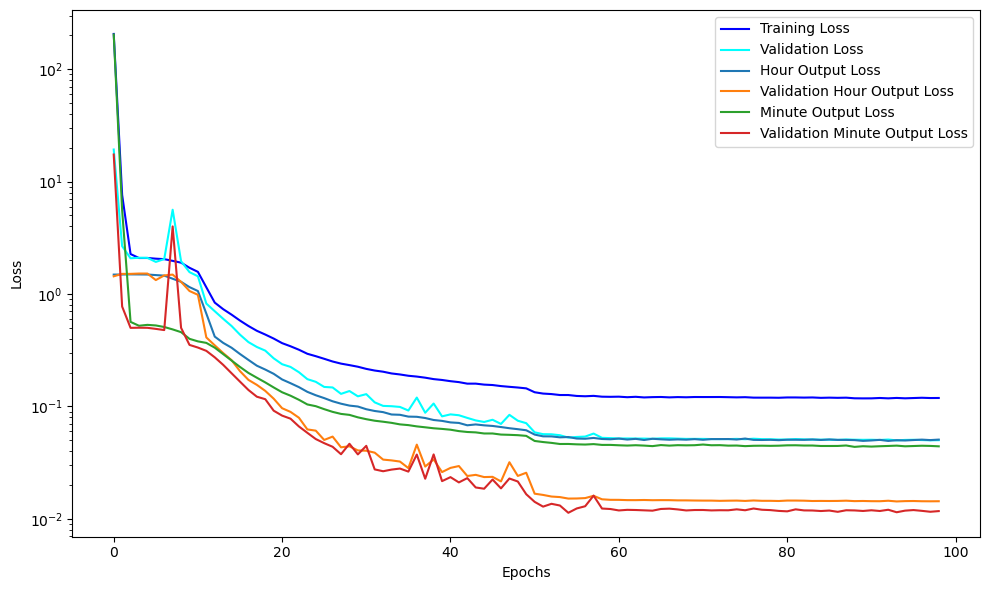

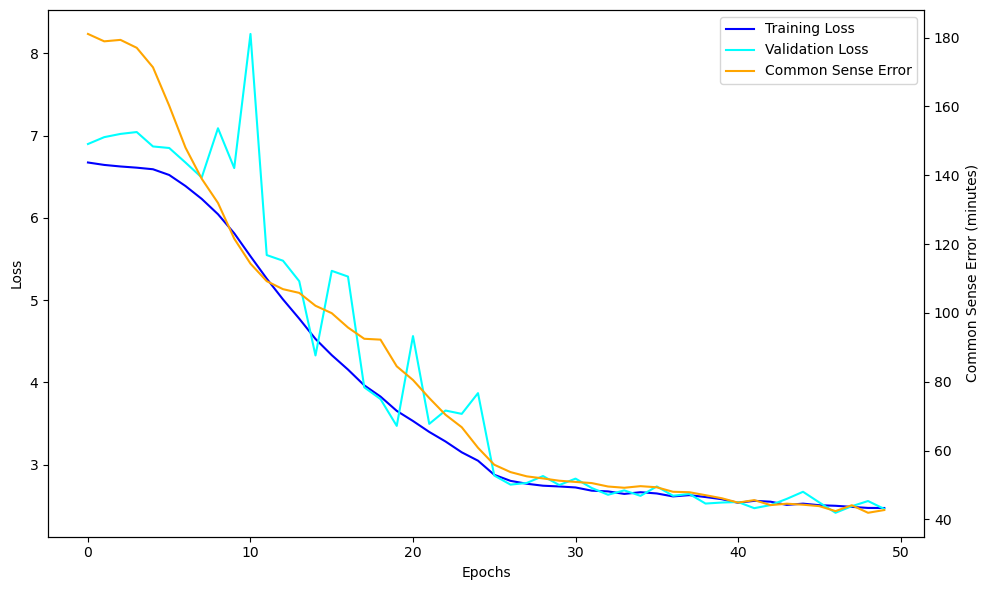

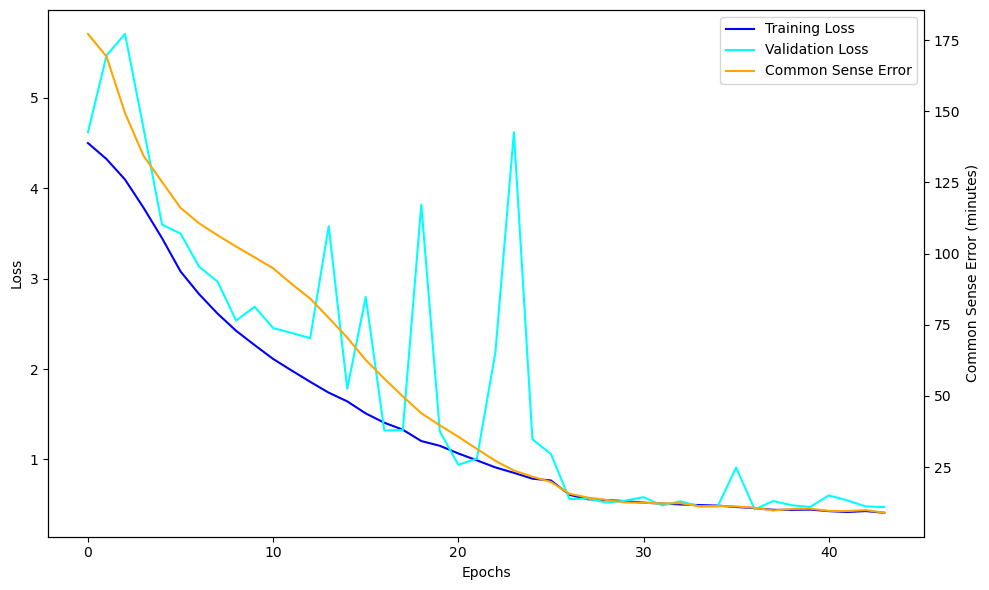

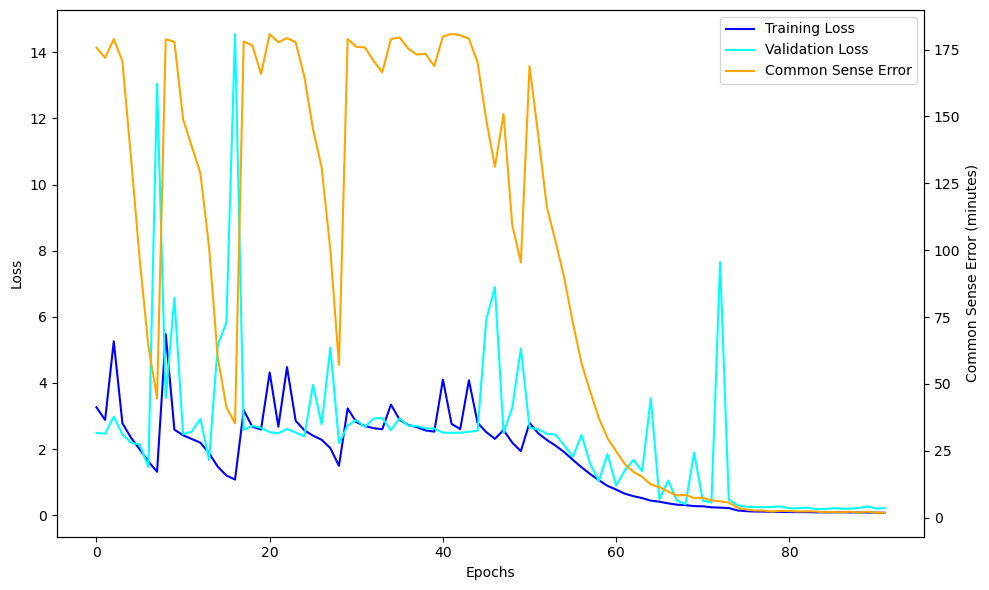

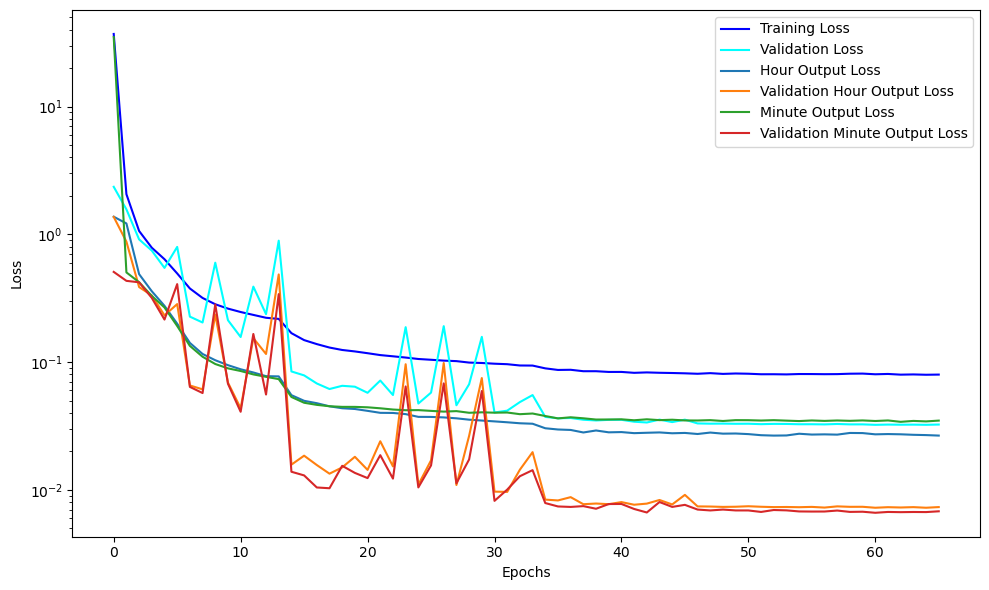

In [65]:
import os
import matplotlib.pyplot as plt
folder_path = "csv_logs"
for filename in os.listdir(folder_path):
    if 'log' in filename:
        file_path = os.path.join(folder_path, filename)
        print(f"Processing file: {file_path}")
        df = pd.read_csv(file_path)
        #plot training and validation loss curves
        fig, ax1 =plt.subplots(figsize=(10,6))
        ax2 = None
        ax1.plot(df['loss'], label='Training Loss', color='blue')
        ax1.plot(df['val_loss'], label='Validation Loss', color='cyan')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        #if there is a column 'common_sense_loss' plot it too on a separate axis
        if 'common_sense_loss' in df.columns:
            ax2 = plt.twinx()
            ax2.plot(df['common_sense_loss'], label='Common Sense Error', color='orange')
            ax2.set_ylabel('Common Sense Error (minutes)')
        #if "dual_head" in filename plot hour and minute output losses & use logarithmic scale
        if 'dual_head' in filename:
            ax1.plot(df['hour_output_loss'], label='Hour Output Loss')
            ax1.plot(df['val_hour_output_loss'], label='Validation Hour Output Loss')
            ax1.plot(df['minute_output_loss'], label='Minute Output Loss')
            ax1.plot(df['val_minute_output_loss'], label='Validation Minute Output Loss')
            ax1.set_yscale('log')
        #create a combined legend
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = [], []
        if ax2 is not None:
            lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')
        fig.tight_layout()
        plt.savefig(f"{filename}_loss_curve.png")
